In [1]:
#Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## DropValues 
### Input:
    df              <DataFrame> to drop values from.
    Percentage      <float> Percentage of values to drop from the DataFrame.

### Returns:
    temp            <DataFrame> containing NaN values for dropped values.
    NAMask          <DataFrame> containing True for dropped values of temp DataFrame.

### Description:
The function DropValues() makes a certain percentage of the data NaN.

In [2]:
def DropValues(df,Percentage):
    
    NAMask = pd.DataFrame(data=np.random.uniform(low=0, high=1, size=df.shape) > Percentage)
    temp = df.copy()
    for i in range(len(temp.index)):
        for o in range(len(temp.columns)):
            if not NAMask.iloc[i,o]:
                temp.iloc[i,o] = np.nan
    return temp

## Data Generation Function
### Input:
    size            <list> [Columns<int>, Index<int>]
    m               <int> What rank matrix will the dataset be?
    sigma_err       <float> What normal error should the final dataset contain? 
                    (based on a standard normally distributed random float)
                    
    
### Returns:
    X_gen           <DataFrame> Generated Dataset with errors
    
### Description:
The function GenerateData() creates a dataset of size _size_. This generator simulates real world data. This generator also applies a standard normally distributed error defined by _sigma_err_.

#### Steps:
    Step 1: Generate DataFrames C_true and D_true. These are of size n x m and p x m respectively. 
    These DataFrames are filled with standard normally distributed values.
    
    Step 2: Subtract the mean from each C_true Column to not model the mean when using PCA
    
    Step 3: Generate DataFrame X_true. This DataFrame contains the dot product of C_true and D_true.
    
    Step 4: Create error and correct for mean per Column.
    
    Step 5: Add error * sigma_err to generated DataFrame
    
    Step 6: ....Profit?! (actually you now have a dataset that simulates real world data, but profit also works)


In [3]:
def GenerateData(size,m=2,sigma_err=0.05, debug = True):
    if debug:
        print("Now generating a rank %i matrix of size %i x %i with an error of %f"%(m, size[0], size[1], sigma_err))
    
    #Generates Matrix C_true with size n x m with standard normally distributed values
    C_true = pd.DataFrame(data=np.random.randn(size[0],m))

    #This makes it so we don't model the mean when using PCA
    C_true = C_true - np.outer(np.full((size[0],1), 1),C_true.mean())
    #Generates Matrix D_true with size p x m with standard normally distributed values
    D_true = pd.DataFrame(data=np.random.randn(size[1],m))

    #Generate true Matrix X using C_true and D_true'
    X_true = pd.DataFrame(data=np.dot(C_true,D_true.transpose()))

    #Add real world errors
    E = pd.DataFrame(data=np.random.randn(size[0],size[1]))

    E = E - np.outer(np.full((size[0],1), 1),E.mean())

    X_gen = X_true + sigma_err * E
    
    return X_gen

    ##Singular Value Decomposition of X_gen
    #svd = np.linalg.svd(X_gen,full_matrices=False)

    ##Reconstruction of X_gen
    #X_gen_r = np.dot(svd[0][:,:m] * svd[1][:m], svd[2][:m,:])

## SVD Iterative Model

### Input:
    X_missings      <list>[Columns<int>, Index<int>]
    m               (optional, default = 2) <int> What rank matrix will the dataset be?
    max_iter        (optional, default = 1000) <int> The maximum amount of iterations PCA should execute.
    exitPower       (optional, default = -6) <int> When the RSS is less than 10 ** exitPower, the model will consider itself trained.
    debug           (optional, default = False) <boolean> Display debug info RSS debug info. 
                    
    
### Returns:
    Xem_rec         <DataFrame> Recreated dataset without missings.
    

### Description:
This method uses Singular Value Decomposition (SVD) to recreate missing datapoints in a few simple steps.

### Steps (really boiled down version of it):
    Step 1: Decompose DataFrame X_missings where NaN is replaced with 0 using SVD.
    
    Step 2: Reconstruct a new DataFrame based on the values from step 1.
    
    Step 3: Replace missing spots with reconstructed data.
    
    Step 4: Calculate RSS.
    
    Step 5: If the difference between RSS and the RSS of the previous iteration is smaller than 10 ** exitPower, return the generated dataset.
    
    Step 6: If this difference is not larger than 10 ** exitPower, redo the previous steps on the new dataset. This method keeps correcting the known values to its originals, thus getting the error closer and closer to 0.
    

In [4]:
def PCAMiss(X_missings, m = 2, maxIter = 1000, debug = False, exitPower = -6):
    n = X_missings.index
    p = X_missings.columns
    
    Xem = X_missings.copy().fillna(0)
    Miss = X_missings.copy().isin([np.nan])
    
    #Calculate Sum-of-Squares
    SSQ = np.nansum((X_missings) ** 2)
    lastRSS = 1
    if debug:
        print("Now iterating over NaN filled matrix using PCA.\n")
    
    for i in range(maxIter):
        svd = np.linalg.svd(Xem, full_matrices=False)
        Xem_rec = np.dot(svd[0][:,:m] * svd[1][:m], svd[2][:m,:])
        Xem = (1 - Miss) * Xem + Miss * Xem_rec
        
        #Calculate Residual Sum-of-Squares
        RSS = np.nansum((X_missings - Xem_rec) ** 2) / SSQ
        
        if debug:
            print("Iteration %i: RSS = %.8f, difference = %.8f"%(i, RSS, lastRSS - RSS))
        
        #Exit Condition
        if (lastRSS-RSS) < (10 ** exitPower):
            if debug:
                print("\nFound acceptable solution within %i iterations!"%(i))
            return pd.DataFrame(data=Xem_rec)
        lastRSS = RSS
    print("\n\n\nError: Reached end of max iterations without converging to successful model.")

# Start of actual model

In [5]:
#Setting random state of Python. This is for reproducibility.
np.random.seed(42)

#How many profiles?
#profiles = int(input("Amount of profiles: "))
profiles = 100
#m = int(input("Dimensions: "))
m = 20
#missPercent = float(input("Enter missings Percentage: "))/100
missPercent = 0.50
#Getting column names of recipes
ColumnNames = pd.read_csv("Generated Datasets/ingr_pivot_lunch_diner_noten.csv")["recipe"]

#Dataset variables.
size = [profiles,len(ColumnNames)] #Size

#Generates Dataset using a rank 2 matrix.
X_gen = GenerateData(size, m = m)

#Pokes holes in the dataset where missPercent of the original matrix dropped.
X_missing = DropValues(X_gen, missPercent)

#Trains and fits model
X_pred = PCAMiss(X_missing, m = m, maxIter = 1000, exitPower = -6, debug = True)

#Apply column names to X_pred
X_pred.columns = list(ColumnNames)
X_pred.index.name = "Users"
X_gen.columns = list(ColumnNames)
X_gen.index.name = "Users"

Now generating a rank 20 matrix of size 100 x 4616 with an error of 0.050000
Now iterating over NaN filled matrix using PCA.

Iteration 0: RSS = 0.19738153, difference = 0.80261847
Iteration 1: RSS = 0.07504811, difference = 0.12233342
Iteration 2: RSS = 0.03698307, difference = 0.03806504
Iteration 3: RSS = 0.02090912, difference = 0.01607395
Iteration 4: RSS = 0.01286142, difference = 0.00804769
Iteration 5: RSS = 0.00837907, difference = 0.00448235
Iteration 6: RSS = 0.00569441, difference = 0.00268466
Iteration 7: RSS = 0.00399937, difference = 0.00169504
Iteration 8: RSS = 0.00288527, difference = 0.00111410
Iteration 9: RSS = 0.00212937, difference = 0.00075591
Iteration 10: RSS = 0.00160305, difference = 0.00052632
Iteration 11: RSS = 0.00122860, difference = 0.00037445
Iteration 12: RSS = 0.00095727, difference = 0.00027133
Iteration 13: RSS = 0.00075753, difference = 0.00019975
Iteration 14: RSS = 0.00060843, difference = 0.00014910
Iteration 15: RSS = 0.00049576, difference =

## Boxplot of the difference between the generated dataset and the predicted dataset

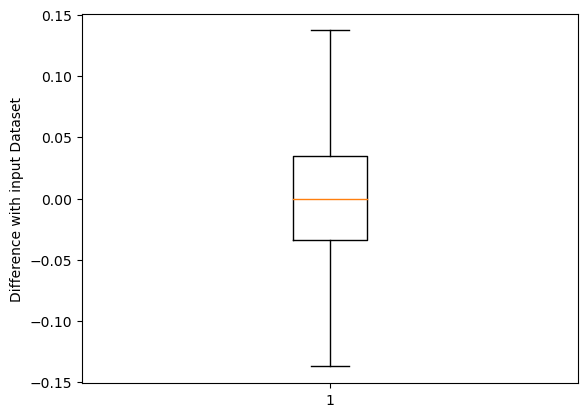

In [12]:
fig, ax = plt.subplots()
VP = ax.boxplot((X_gen-X_pred).to_numpy().flatten().transpose(), showfliers=False)
flattenedX_gen = np.std(X_gen.to_numpy().flatten())
#plt.axhline(y = flattenedX_gen, color = 'r', linestyle = '-')
#plt.axhline(y = -flattenedX_gen, color = 'r', linestyle = '-')
ax.set_ylabel("Difference with input Dataset")
plt.show()

In [8]:
X_pred.to_csv("PCADataset.csv")

In [11]:
X_pred

,Andijviestamppot met gebakken salami,Libanese wraps met appel-koolsalade,Plaattaart met gegrilde groenten en witte kaas,Zalmspies met sojaglaze van de BBQ,&amp;Suus’ buik-weg-salade,'Burrito'-schotel met knapperige tortillapuntjes,'Foeyonghai' met bami,'Kapsalon' met&nbsp;vegetarische&nbsp;kipshoarma en salade,'Leeuwenkoppen' van gehakt en kool,'Marokkaanse' lamsbout,...,Zwarte-bonenstoof met feta,Zwartebonen-rijstsalade met avocado &amp; witte kaas,Zwartebonenchili met kip,Zwartebonenstoof met tofu en gordita's,Zweedse balletjes,Zweedse gehaktballetjes,Zweedse gehaktballetjes met room,Zweedse vegaballetjes met aardappel &amp; broccoli,Zwitserse kaasfondue,‘Nasi’ met Hollandse soepgroente
Users,,,,,,,,,,,,,,,,,,,,,
0,1.138796,1.056479,3.660292,-3.544616,-4.690892,4.992469,2.499244,-3.771950,-1.306715,3.472862,...,3.500844,1.097106,-8.232365,-5.726054,-4.019998,-1.610980,-3.053189,11.136780,-4.978079,-5.372205
1,3.988656,-2.139001,-4.018796,1.755067,10.322247,9.157542,2.481650,4.136016,-11.340420,6.235721,...,-4.426265,-3.661666,-0.491270,-0.974006,-1.480171,-1.463224,3.899049,-2.399681,3.080080,7.257601
2,0.549593,8.807267,-1.013544,-2.249003,-0.335313,-0.321091,-1.296839,1.209383,-0.993558,-2.476854,...,-1.854658,0.766899,0.187451,3.347980,1.227955,4.420414,1.262780,-2.188302,5.021789,6.160034
3,-3.029138,2.332338,2.584326,2.792733,-4.741320,-2.486378,4.321931,6.589517,1.278114,-5.632026,...,4.949113,-2.038314,-5.420995,-0.333203,4.449514,-5.699070,-0.532151,6.954242,5.226249,-2.195984
4,0.241905,1.690099,1.525461,0.012232,0.234512,-1.784614,-0.373672,-0.125189,-4.155616,-0.488487,...,-0.695108,-2.595215,-5.453966,-0.179992,3.503500,2.545738,-2.079258,-4.249956,-2.699734,1.099229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-5.525673,-5.512956,2.063376,7.659901,-2.456395,0.755586,3.311180,10.874433,5.234498,2.910039,...,-3.567270,-5.679812,-4.145716,-7.983600,-2.726644,-5.314808,-3.323411,4.962264,1.972739,2.386290
96,5.045152,-16.857518,-3.458804,6.856495,5.348447,-0.597038,-2.062037,-1.161515,4.692553,1.530710,...,-0.422012,5.725019,0.661219,-4.727220,0.154243,-7.673118,4.285702,-15.894704,1.539617,-0.802987
97,-3.393795,-3.208672,0.837538,2.915889,-7.683360,-6.899115,1.000865,2.377798,7.861380,-3.210643,...,9.500527,7.748446,-4.038904,-8.147333,-4.354717,-2.372761,-0.023411,5.590345,3.395976,4.090734
